# Spleen 3D segmentation with [MEDICAI](https://github.com/innat/medic-ai)

This tutorials shows how to use [medicai](https://github.com/innat/medic-ai), a [keras](https://keras.io/) based multi-backend medical image processing library to solve spleen segmentation task. 


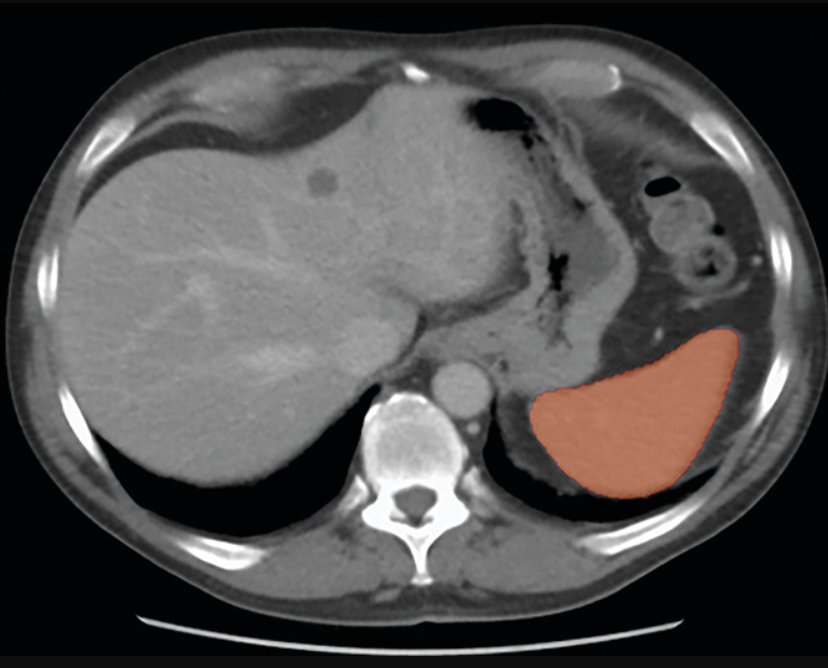


<div style="text-align: center;">
  <p><strong>Figure:</strong> This scan is taken from <a href="https://www.ajronline.org/doi/10.2214/ajr.23.29478" target="_blank">https://www.ajronline.org/doi/10.2214/ajr.23.29478</a>. A 50-year-old man who underwent contrast-enhanced CT for evaluation of patient as potential renal donor. Patient weight was 84.8 kg. Automated deep learning artificial intelligence tool was used to segment spleen and thereby compute splenic volume.</p>
</div>

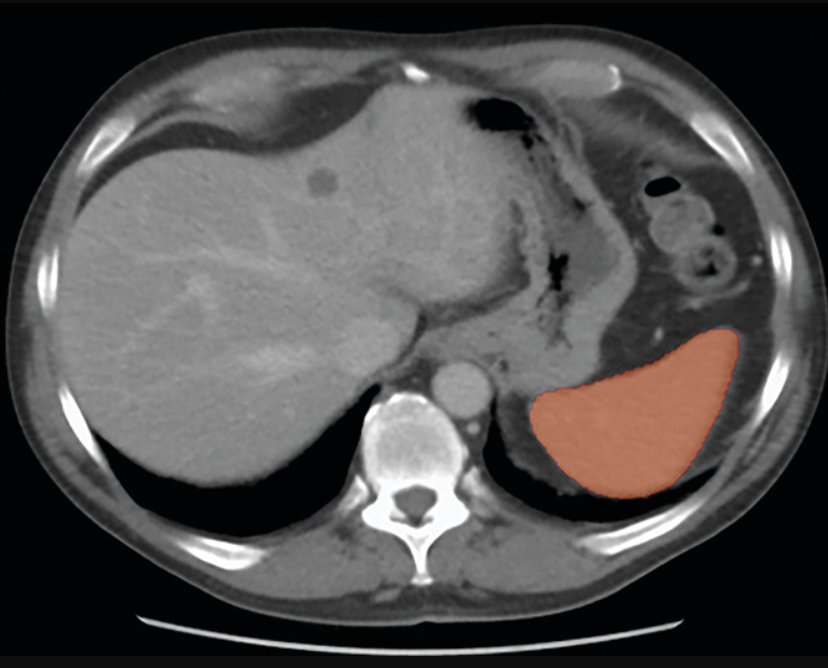

In [1]:
from IPython.display import clear_output

!pip install keras -qU
!pip install git+https://github.com/innat/medic-ai.git -q

clear_output()

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import nibabel as nib
from matplotlib import pyplot as plt

In [3]:
os.environ["KERAS_BACKEND"] = "tensorflow" # tensorflow, torch, jax

from medicai.utils.general import hide_warnings
hide_warnings()

import keras
import tensorflow as tf

from medicai.models import SwinUNETR
from medicai.transforms import (
    Compose,
    ScaleIntensityRange,
    CropForeground,
    RandSpatialCrop,
    Spacing,
    Orientation,
    RandCropByPosNegLabel,
    RandShiftIntensity,
    RandRotate90,
    RandFlip
)

keras.utils.set_random_seed(101)
keras.config.set_dtype_policy("mixed_float16")
keras.backend.backend(), keras.version(), tf.__version__

E0000 00:00:1745404985.944706      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745404985.986557      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


('tensorflow', '3.9.2', '2.18.0')

# Dataset

We will get the dataset from http://medicaldecathlon.com/.

In [4]:
import keras
from keras.utils import get_file

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
root_dir = "/kaggle/working/"

path = keras.utils.get_file(
    fname="Task09_Spleen.tar",
    origin=resource,
    md5_hash=md5,
    cache_dir=root_dir,
    cache_subdir=".",
    extract=True,
    archive_format="tar",
    force_download=False,
)

1610352640/1610352640 ━━━━━━━━━━━━━━━━━━━━ 77s 0us/step


In [5]:
data_path = f'{root_dir}Task09_Spleen_extracted/Task09_Spleen'

with open(os.path.join(data_path, 'dataset.json')) as f:
    meta_info = json.load(f)

This dataset doesn't provide ground truth for validation dataset. So, we will keep some data apart from training set for validation.

In [6]:
all_images = []
all_labels = []

for i in meta_info['training']:
    image = os.path.normpath(os.path.join(data_path, i['image']))
    label = os.path.normpath(os.path.join(data_path, i['label']))
    all_images.append(image)
    all_labels.append(label)

print(len(all_images), len(all_labels))

41 41


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_images, 
    all_labels,
    test_size=0.10,
    random_state=42
)
print('Verify number of samples per dataset')
print(len(X_train), len(y_train), len(X_test), len(y_test))

Verify number of samples per dataset
36 36 5 5


# Transformation

In [8]:
def train_transformation(image, label, affine):
    data = {"image": image, "label": label}
    meta = {"affine": affine}
    pipeline = Compose(
        [
            Orientation(keys=["image", "label"], axcodes="RAS"),
            Spacing(
                keys=["image", "label"],
                pixdim=(2.0, 1.5, 1.5),
                mode=("bilinear", "nearest"),
            ),
            CropForeground(keys=["image", "label"], source_key="image"),
            ScaleIntensityRange(
                keys=["image"],
                a_min=-57,
                a_max=164,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
            RandCropByPosNegLabel(
                keys=("image", "label"),
                spatial_size=[96, 96, 96], 
                pos=1, 
                neg=1, 
                num_samples=1,
                image_reference_key='image',
                image_threshold=0,
            ),
            RandFlip(keys=["image", "label"], spatial_axis=[0], prob=0.5),
            RandFlip(keys=["image", "label"], spatial_axis=[1], prob=0.5),
            RandFlip(keys=["image", "label"], spatial_axis=[2], prob=0.5),
            RandRotate90(
                keys=["image", "label"], 
                prob=0.6, 
                max_k=3, 
                spatial_axes=(1, 2)
            ),
            RandShiftIntensity(keys=["image"], offsets=0.10, prob=0.6)
        ]
    )
    result = pipeline(data, meta)
    return result["image"], result["label"]

def val_transformation(image, label, affine):
    data = {"image": image, "label": label}
    meta = {"affine": affine}
    pipeline = Compose(
        [
            Orientation(keys=["image", "label"], axcodes="RAS"),
            Spacing(
                keys=["image", "label"],
                pixdim=(2.0, 1.5, 1.5),
                mode=("bilinear", "nearest"),
            ),
            CropForeground(keys=["image", "label"], source_key="image"),
            ScaleIntensityRange(
                keys=["image"],
                a_min=-57,
                a_max=164,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
        ]
    )
    result = pipeline(data, meta)
    return result["image"], result["label"]

# Dataloader

In [9]:
class NiftiDataLoader(keras.utils.PyDataset):
    def __init__(
        self, 
        image_paths, 
        label_paths,
        batch_size=1, 
        dim=(128, 128, 128), 
        shuffle=True, 
        training=True
    ):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.training = training
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        # issue: https://github.com/keras-team/keras/issues/20001
        if index >= self.__len__():
            raise StopIteration
            
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        image_paths_batch = [self.image_paths[k] for k in indices]
        labels_batch = [self.label_paths[k] for k in indices]
    
        X = []
        y = []
    
        for image_path, label_path in zip(image_paths_batch, labels_batch):
            image_nii = nib.load(image_path)
            label_nii = nib.load(label_path)
    
            image = image_nii.get_fdata().astype(np.float32)
            label = label_nii.get_fdata().astype(np.float32)
            affine = image_nii.affine.astype(np.float32)
    
            image = np.transpose(image, (2, 1, 0))  # whd → dhw
            label = np.transpose(label, (2, 1, 0))
            affine[:, :3] = affine[:, [2, 1, 0]]
    
            # Add channel dimension
            image = image[..., np.newaxis] if image.ndim == 3 else image
            label = label[..., np.newaxis] if label.ndim == 3 else label
    
            if self.training:
                image, label = train_transformation(image, label, affine)
                X.append(image)
                y.append(label)
            else:
                image, label = val_transformation(image, label, affine)
                X.append(image)
                y.append(label)

        # Stack only after dynamic sizing
        X = np.stack(X, axis=0)
        y = np.stack(y, axis=0)
    
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [10]:
input_shape=(96, 96, 96)

train_loader = NiftiDataLoader(
    image_paths=X_train,
    label_paths=y_train,
    batch_size=6,
    dim=input_shape,
    shuffle=True,
    training=True
)

val_loader = NiftiDataLoader(
    image_paths=X_test,
    label_paths=y_test,
    batch_size=1,
    dim=input_shape,
    shuffle=False,
    training=False
)

In [11]:
x, y = next(iter(val_loader))
x.shape, y.shape

I0000 00:00:1745405081.234535      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745405081.235164      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


((1, 126, 209, 273, 1), (1, 126, 209, 273, 1))

In [12]:
if len(x[0]) > 1:
    train_x, train_y = x[0], y[0]
    train_x, train_y = train_x[None, ...], train_y[None, ...]

test_image = train_x.squeeze()
test_mask = train_y.squeeze()
print(test_image.shape, test_mask.shape, np.unique(test_mask))
print(test_image.min(), test_image.max())

(126, 209, 273) (126, 209, 273) [0. 1.]
0.0 1.0


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image[test_image.shape[0]//2], cmap='gray')
ax1.set_title(f'Image shape: {test_image.shape}')
ax2.imshow(test_mask[test_mask.shape[0]//2])
ax2.set_title(f'Label shape: {test_mask.shape}')
plt.show()

# Model

In [14]:
from keras import ops
from medicai.models import SwinUNETR
from medicai.metrics import BinaryDiceMetric
from medicai.losses import BinaryDiceLoss

num_classes=1
input_shape = (96, 96, 96, 1)

model = SwinUNETR(
    input_shape=input_shape,
    num_classes=num_classes,
    classifier_activation=None,
)

model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5,
    ),
    loss=BinaryDiceLoss(
        from_logits=True, 
        num_classes=num_classes
    ),
    metrics=[
        BinaryDiceMetric(
            from_logits=True,
            ignore_empty=True,
            num_classes=num_classes,
            name='dice',
        )
    ],
)

model.summary()

62.186659

## Sliding Window Inference Callback

In [15]:
from medicai.callbacks import SlidingWindowInferenceCallback


swi_callback_metric = BinaryDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='val_dice',
)

swi_callback = SlidingWindowInferenceCallback(
    model,
    dataset=val_loader, 
    metrics=swi_callback_metric,
    num_classes=num_classes,
    interval=5, 
    overlap=0.6,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    save_path="spleen.model.weights.h5",
    logging=True
)

In [ ]:
history = model.fit(
    train_loader, 
    epochs=700,
    callbacks=[
        swi_callback
    ]
)

**Visualize**

In [ ]:
# In our `SlidingWindowInferenceCallback`, we set `logging=True` and `interval=5`.  
# Enabling `logging` adds a validation score, named `swi_{swi_callback_metric.name}`, -
# to the Keras log history.  
# However, because `interval=5`, this metric is logged every 5 epochs, resulting in -
# varying lengths across keys in the Keras log history.

print(model.history.history.keys())
swi_val_dice = model.history.history.pop('swi_val_dice')
his_csv = pd.DataFrame(model.history.history)
his_csv.to_csv('spleen.history.csv')
his_csv.head()

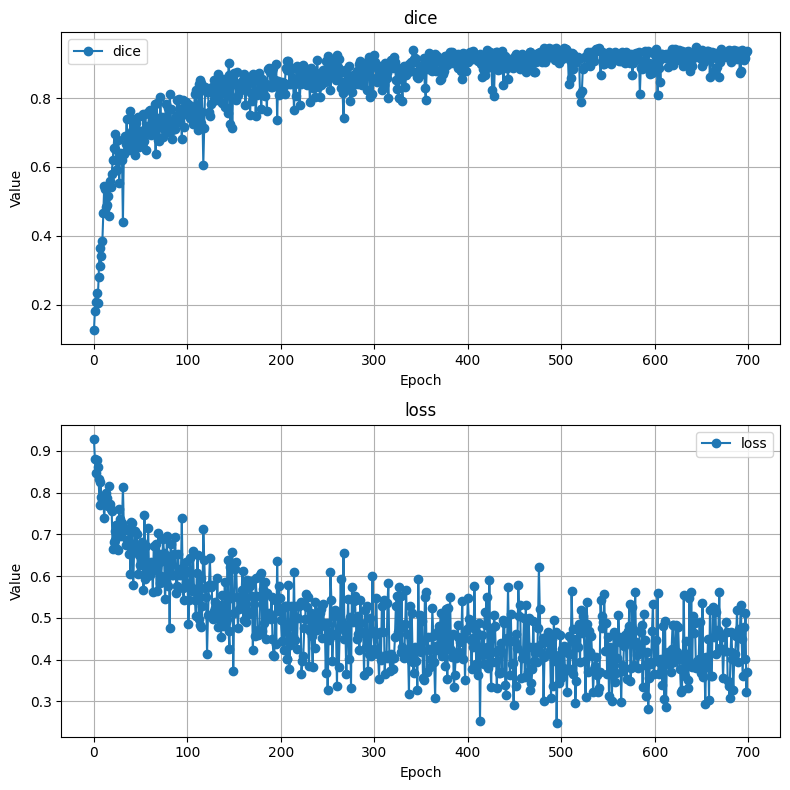

In [ ]:
def plot_training_history(history_df):
    metrics = history_df.columns
    n_metrics = len(metrics)
    
    n_rows = 2
    n_cols = (n_metrics + 1) // 2 

    plt.figure(figsize=(8 * n_cols, 4 * n_rows))
    
    for idx, metric in enumerate(metrics):
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.plot(history_df[metric], label=metric, marker='o')
        plt.title(metric)
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(his_csv)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(swi_val_dice)), swi_val_dice, marker='o', linestyle='-')
plt.title('SWI Validation Dice Score over Epochs - interval 5')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation

In [18]:
from keras import ops
from medicai.utils.inference import SlidingWindowInference

model.load_weights(
    'spleen.model.weights.h5'
)
swi = SlidingWindowInference(
    model,
    num_classes=num_classes,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    overlap=0.6,
)

dice = BinaryDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='dice',
)

In [20]:
val_x_list, val_y_list, val_y_pred_list = [], [], []

for x, y in val_loader:
    output = swi(x)
    
    y = ops.convert_to_tensor(y)
    output = ops.convert_to_tensor(output)
    dice.update_state(y, output)

    val_x_list.append(x)
    val_y_list.append(y)
    val_y_pred_list.append(output)

dice_score = float(ops.convert_to_numpy(dice.result()))
print(f"Dice Score: {dice_score:.4f}")
dice.reset_states()

Total patch 32: 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

Dice Score: 0.7120


# Visualization

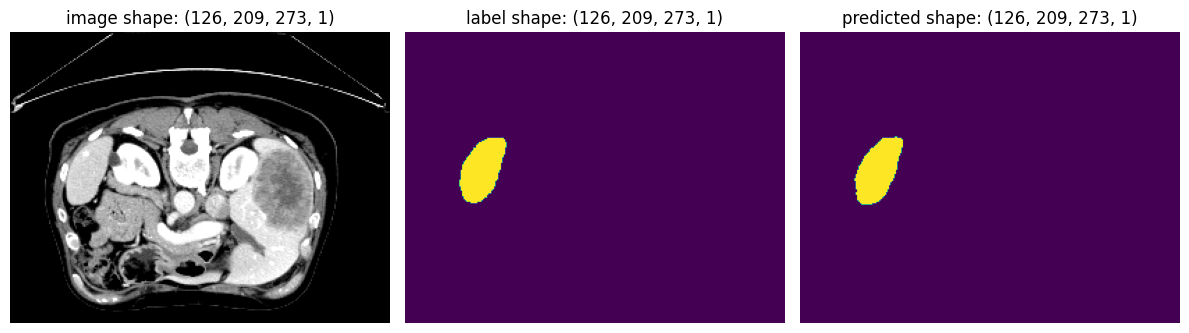

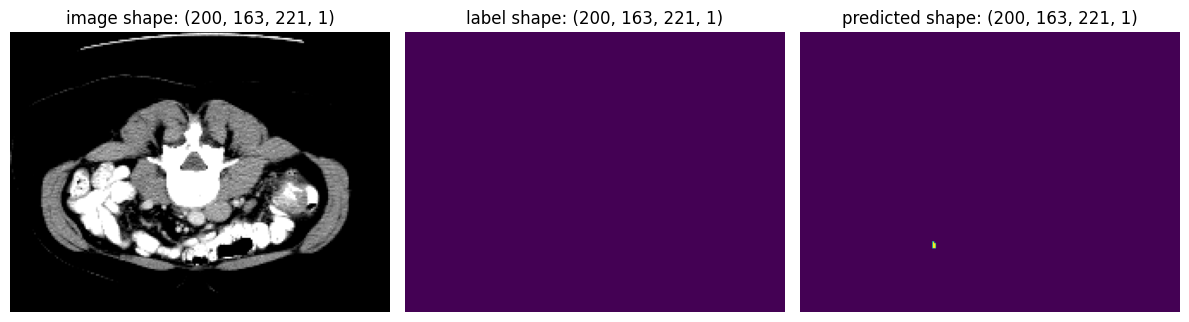

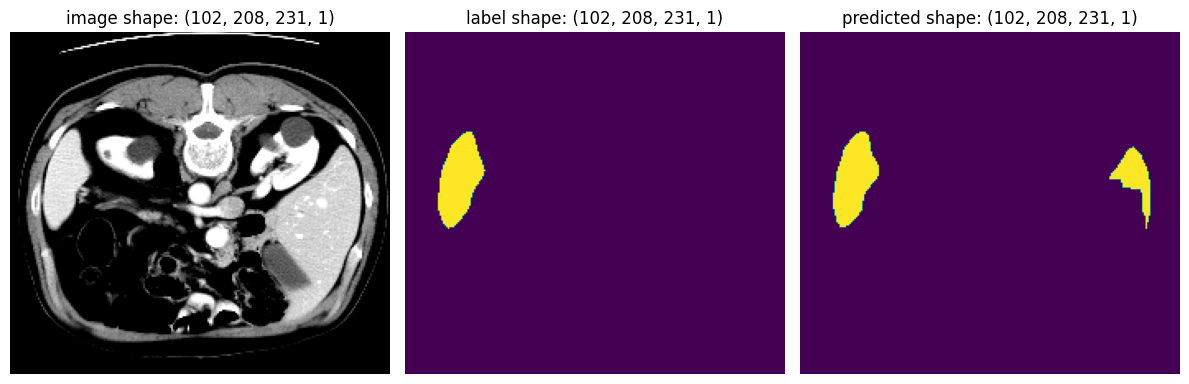

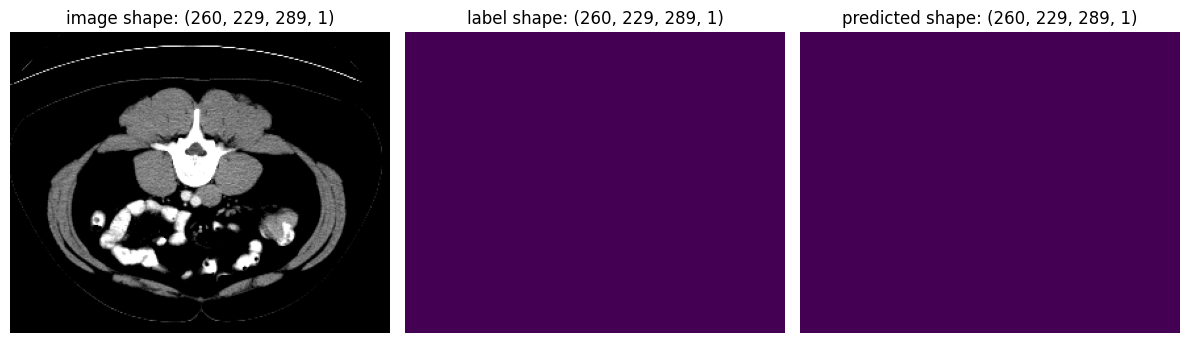

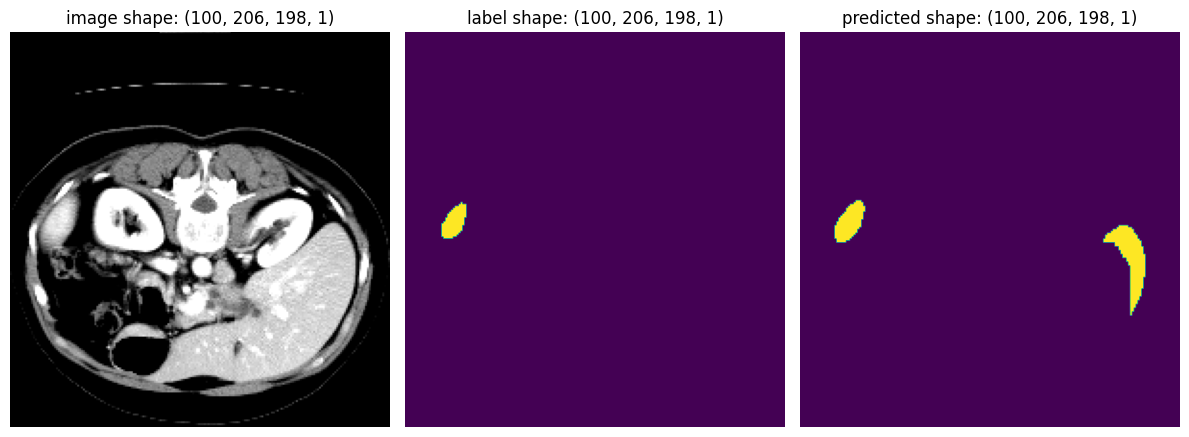

In [21]:
for x, y, y_pred in zip(val_x_list, val_y_list, val_y_pred_list):
    # Post-processing
    pred_label = ops.sigmoid(y_pred) > 0.5
    pred_label = ops.convert_to_numpy(pred_label).squeeze(0).astype(int)

    true_image = np.squeeze(x, axis=0)
    true_label = np.squeeze(y, axis=0).astype(int)

    # Visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

    mid_slice = true_image.shape[0] // 2
    
    ax1.imshow(true_image[mid_slice], cmap='gray')
    ax1.set_title(f'image shape: {true_image.shape}')
    ax1.set_axis_off()

    ax2.imshow(true_label[mid_slice])
    ax2.set_title(f'label shape: {true_label.shape}')
    ax2.set_axis_off()

    ax3.imshow(pred_label[mid_slice])
    ax3.set_title(f'predicted shape: {pred_label.shape}')
    ax3.set_axis_off()

    plt.grid(visible=False)
    plt.tight_layout()
    plt.show()


**Improvement Plan**

- Support larger patch sizes during inference by allowing `SlidingWindowInference(roi_size)` to exceed the input shape defined in `SwinUNETR(input_shape)`. Currently, input shape is same for training and inference.
- Enable multi-patch extraction by setting `num_samples > 1` in `RandCropByPosNegLabel`, allowing multiple crops per input.
